[*********************100%***********************]  1 of 1 completed


VIX normalized range: -2.54 to 15.00


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


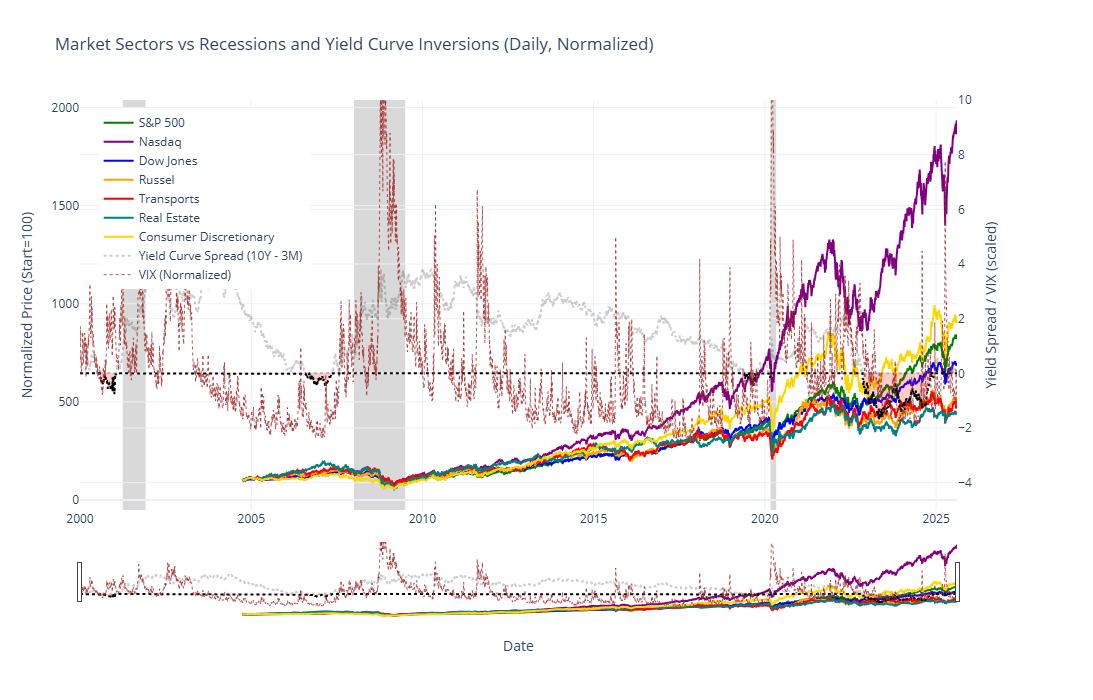

In [38]:
import pandas as pd
import yfinance as yf
from datetime import datetime
import pandas_datareader.data as web
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Set time range
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
# Reindex to ensure continuous daily dates and forward-fill missing values
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Load US Recession indicator from FRED
recession_data = web.DataReader('USREC', 'fred', start=start_date, end=end_date)

# Download VIX data
vix_df = yf.download("^VIX", auto_adjust=True, start=start_date, end=end_date)
vix = vix_df['Close']

# Handle VIX columns
if isinstance(vix_df.columns, pd.MultiIndex):
    close_cols = [col for col in vix_df.columns if 'Close' in str(col)]
    vix = vix_df[close_cols[0]] if close_cols else vix_df.iloc[:, -1]
else:
    vix = vix_df['Close'] if 'Close' in vix_df.columns else vix_df.iloc[:, -1]

#print(f"VIX data shape: {vix.shape}")
#print(f"VIX date range: {vix.index.min()} to {vix.index.max()}")
#print(f"VIX range: {vix.min():.2f} to {vix.max():.2f}")

vix_aligned = vix.reindex(date_range).ffill()

# Normalize VIX around 0 for secondary axis
# This scales VIX to roughly -3 to +3 range to share axis with yield spreads
vix_mean = vix_aligned.mean()
vix_std = vix_aligned.std()
vix_normalized = (vix_aligned - vix_mean) / vix_std * 2  # Scale to ±2 standard deviations

print(f"VIX normalized range: {vix_normalized.min():.2f} to {vix_normalized.max():.2f}")



# Download IRX (13-week yield) and TNX (10-year yield)
yields = yf.download(["^IRX", "^TNX"], start=start_date, end=end_date, auto_adjust=True)
irx = yields['Close']['^IRX']  # 13-week yield
tnx = yields['Close']['^TNX']  # 10-year yield

# Calculate spread and ensure continuous date index
spread = tnx - irx 
spread.name = "Yield Curve Spread"
spread = spread[start_date:end_date]

# Reindex to ensure continuous daily dates and forward-fill missing values
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
spread = spread.reindex(date_range).ffill()

# Define tickers
tickers = {
    'S&P 500': {'symbol': 'SPY', 'color': 'green'},
    'Nasdaq': {'symbol': 'QQQ', 'color': 'purple'},
    'Dow Jones': {'symbol': 'DIA', 'color': 'blue'},
    'Russel': {'symbol': 'IWM', 'color': 'orange'},
    'Transports': {'symbol': '^DJT', 'color': 'red'},
    'Real Estate': {'symbol': 'VNQ', 'color': 'teal'},
    'Consumer Discretionary': {'symbol': 'XLY', 'color': 'gold'}
}

# Download data
data = {}
for label, info in tickers.items():
    df = yf.download(info['symbol'], auto_adjust=True, start=start_date, end=end_date)
    price_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
    data[label] = df[price_col]

# Combine into one DataFrame
df_all = pd.concat(data, axis=1)

# Drop rows with any missing data
df_all.dropna(inplace=True)

# Normalize to 100 at start
df_normalized = df_all / df_all.iloc[0] * 100

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

for i, col in enumerate(df_normalized.columns):
    symbol = col[0]  # First level (e.g., "fancy name")
    ticker = col[1]   # Second level (e.g., "ticker")
    fig.add_trace(go.Scatter(
        x=df_normalized.index,
        y=df_normalized[col],
        mode='lines',
        name=symbol,
        line=dict(color=tickers[symbol]['color'])
    ))



# Identify inverted periods (spread < 0)
inverted = spread < 0

# Create two traces: one for positive spreads (no fill) and one for negative spreads (with fill)
# To avoid gaps, we'll split the data into segments based on inversion status changes
spread_positive = spread.copy()
spread_negative = spread.copy()
spread_positive[~inverted] = spread  # Keep positive values
spread_positive[inverted] = 0        # Set negative values to 0
spread_negative[inverted] = spread   # Keep negative values
spread_negative[~inverted] = 0       # Set positive values to 0

# Add trace for positive spread (no fill, just the line)
fig.add_trace(go.Scatter(
    x=spread.index,
    y=spread_positive,
    mode='lines',
    name='Yield Curve Spread (10Y - 3M)',
    line=dict(color='black', dash='dot'),
    opacity=0.2,
    showlegend=True
), secondary_y=True)

# Add trace for negative spread (with fill to y=0)
fig.add_trace(go.Scatter(
    x=spread.index,
    y=spread_negative,
    mode='lines',
    name='Inverted Yield Curve',
    line=dict(color='black', dash='dot'),
    fill='tozeroy',  # Fill to y=0
    fillcolor='rgba(255, 0, 0, 0.2)',  # Red shading with opacity
    opacity=0.2,
    showlegend=False  # Avoid duplicate legend entry
), secondary_y=True)

# OPTION 2: Only show high VIX spikes (VIX > 25)
vix_spikes = vix_normalized.copy()
vix_spikes[vix_aligned < 25] = None  # Hide when VIX < 25

# Add VIX on secondary axis with custom hover showing original values
fig.add_trace(go.Scatter(
    x=vix_aligned.index,
    y=vix_normalized,
    #y=vix_spikes,
    mode='lines',
    name='VIX (Normalized)',
    line=dict(color='brown', width=1, dash='dot'),
    customdata=vix_aligned,  # Original VIX values for hover
    hovertemplate='<b>VIX</b><br>Date: %{x}<br>VIX Value: %{customdata:.2f}<br>Normalized: %{y:.2f}<extra></extra>',
    opacity=0.8
), secondary_y=True)

#print("vix_scaled: head")
#print(vix_scaled.head())
#print(vix.head())


# Add recession shading
for i in range(1, len(recession_data)):
    if recession_data['USREC'].iloc[i-1] == 0 and recession_data['USREC'].iloc[i] == 1:
        start_recession = recession_data.index[i]
    elif recession_data['USREC'].iloc[i-1] == 1 and recession_data['USREC'].iloc[i] == 0:
        end_recession = recession_data.index[i]
        fig.add_vrect(
            x0=start_recession, x1=end_recession,
            fillcolor="gray", opacity=0.3, line_width=0, layer="below"
        )
        

# Layout
fig.update_layout(
    title='Market Sectors vs Recessions and Yield Curve Inversions (Daily, Normalized)',
    height=700,
    xaxis=dict(title='Date', rangeslider=dict(visible=True)),
    yaxis=dict(title='Normalized Price (Start = 100)'),
    yaxis2=dict(
        title='Yield Spread (%)',
        overlaying='y',
        side='right'
    ),
    #legend=dict(orientation='h', y=-0.3, x=0.5, xanchor='center'),
    legend=dict(
        orientation='v',  # Vertical legend
        x=0.02,           # Slightly offset from left edge
        y=0.98,           # Slightly below top edge
        xanchor='left',   # Anchor legend's left side
        yanchor='top'     # Anchor legend's top
    ),
    template='plotly_white',
    hovermode='x unified'
)

fig.update_layout(
    xaxis=dict(range=[start_date, end_date])
)

fig.update_yaxes(title_text='Normalized Price (Start=100)', secondary_y=False)
fig.update_yaxes(title_text='Yield Spread / VIX (scaled)', secondary_y=True)
fig.update_yaxes(range=[-5, 10], secondary_y=True)

fig.show()

[*********************100%***********************]  2 of 2 completed


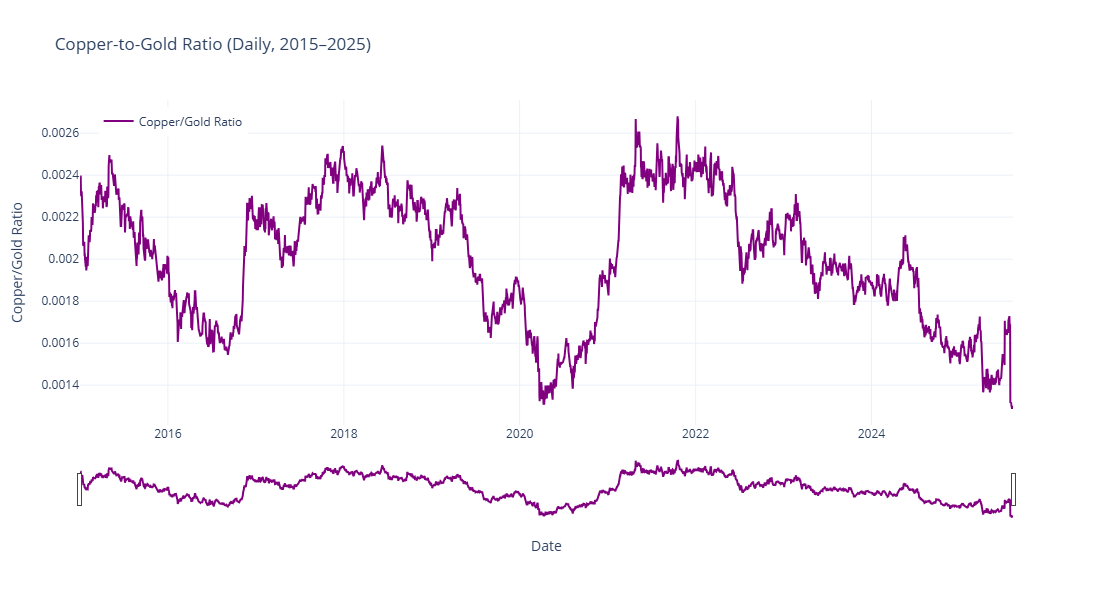

In [21]:
import pandas as pd
import yfinance as yf
from datetime import datetime
import plotly.graph_objects as go

# Set time range
start_date = '2015-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Download copper and gold prices (COMEX futures: HG=F for copper, GC=F for gold)
commodities = yf.download(["HG=F", "GC=F"], start=start_date, end=end_date, auto_adjust=True)
copper = commodities['Close']['HG=F']  # Copper price per pound
gold = commodities['Close']['GC=F']    # Gold price per troy ounce

# Calculate copper-to-gold ratio (copper price per pound / gold price per troy ounce)
copper_gold_ratio = copper / gold
copper_gold_ratio.name = "Copper/Gold Ratio"

# Reindex to ensure continuous daily dates and forward-fill missing values
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
copper_gold_ratio = copper_gold_ratio.reindex(date_range).ffill()

# Create figure
fig = go.Figure()

# Add copper-to-gold ratio trace
fig.add_trace(go.Scatter(
    x=copper_gold_ratio.index,
    y=copper_gold_ratio,
    mode='lines',
    name='Copper/Gold Ratio',
    line=dict(color='purple'),
    showlegend=True
))

# Layout
fig.update_layout(
    title='Copper-to-Gold Ratio (Daily, 2015–2025)',
    height=600,
    xaxis=dict(title='Date', rangeslider=dict(visible=True)),
    yaxis=dict(title='Copper/Gold Ratio'),
    legend=dict(
        orientation='v',
        x=0.02,
        y=0.98,
        xanchor='left',
        yanchor='top'
    ),
    template='plotly_white',
    hovermode='x unified'
)

fig.update_layout(
    xaxis=dict(range=[start_date, end_date])
)

fig.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

SPY data shape: (3925,)
SPY date range: 2010-01-04 00:00:00 to 2025-08-11 00:00:00
VIX data shape: (3925,)
VIX date range: 2010-01-04 00:00:00 to 2025-08-11 00:00:00
VIX range: 9.14 to 82.69
VIX normalized range: -2.68 to 18.66
Showing chart...


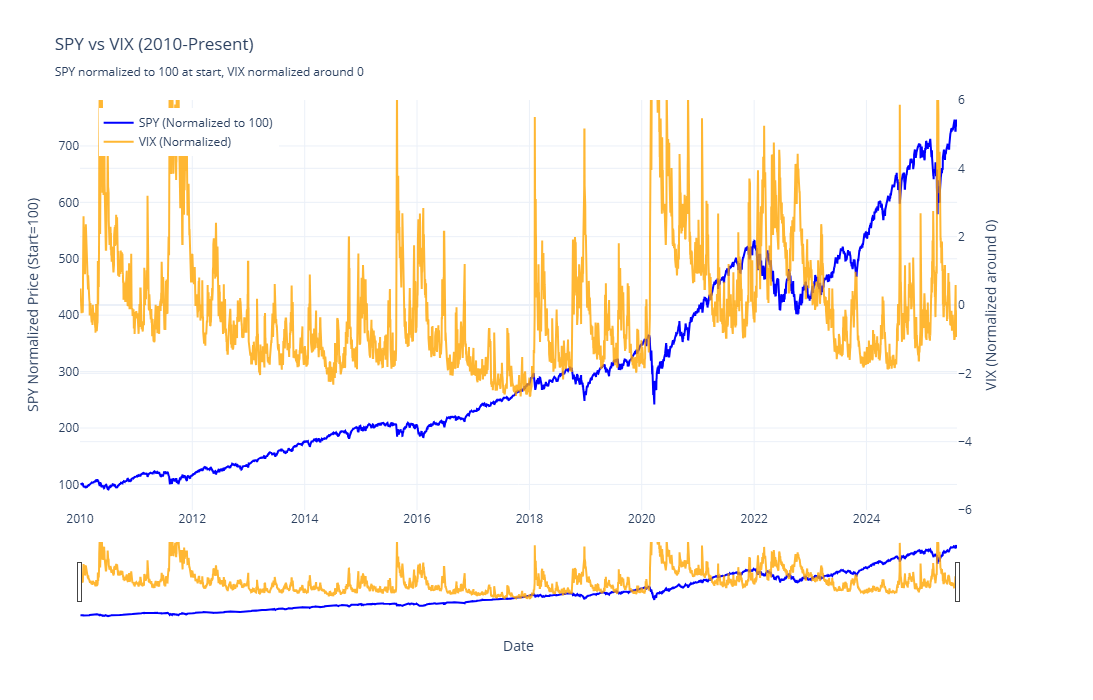


Data Summary:
SPY: 5703 data points
VIX: 5703 data points
SPY final normalized value: 743.63
VIX current value: 16.25
VIX current normalized: -0.61


In [29]:
import pandas as pd
import yfinance as yf
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set time range
start_date = '2010-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Download SPY data
print("Downloading SPY data...")
spy_df = yf.download("SPY", auto_adjust=True, start=start_date, end=end_date)

# Handle SPY columns
if isinstance(spy_df.columns, pd.MultiIndex):
    close_cols = [col for col in spy_df.columns if 'Close' in str(col)]
    spy = spy_df[close_cols[0]] if close_cols else spy_df.iloc[:, -1]
else:
    spy = spy_df['Close'] if 'Close' in spy_df.columns else spy_df.iloc[:, -1]

# Normalize SPY to start at 100
spy_normalized = spy / spy.iloc[0] * 100

print(f"SPY data shape: {spy.shape}")
print(f"SPY date range: {spy.index.min()} to {spy.index.max()}")

# Download VIX data
print("Downloading VIX data...")
vix_df = yf.download("^VIX", auto_adjust=True, start=start_date, end=end_date)

# Handle VIX columns
if isinstance(vix_df.columns, pd.MultiIndex):
    close_cols = [col for col in vix_df.columns if 'Close' in str(col)]
    vix = vix_df[close_cols[0]] if close_cols else vix_df.iloc[:, -1]
else:
    vix = vix_df['Close'] if 'Close' in vix_df.columns else vix_df.iloc[:, -1]

print(f"VIX data shape: {vix.shape}")
print(f"VIX date range: {vix.index.min()} to {vix.index.max()}")
print(f"VIX range: {vix.min():.2f} to {vix.max():.2f}")

# Create date range and align data
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
spy_aligned = spy_normalized.reindex(date_range).ffill()
vix_aligned = vix.reindex(date_range).ffill()

# Normalize VIX around 0 for secondary axis
# This scales VIX to roughly -3 to +3 range to share axis with yield spreads
vix_mean = vix_aligned.mean()
vix_std = vix_aligned.std()
vix_normalized = (vix_aligned - vix_mean) / vix_std * 2  # Scale to ±2 standard deviations

print(f"VIX normalized range: {vix_normalized.min():.2f} to {vix_normalized.max():.2f}")

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add SPY on primary axis
fig.add_trace(go.Scatter(
    x=spy_aligned.index,
    y=spy_aligned,
    mode='lines',
    name='SPY (Normalized to 100)',
    line=dict(color='blue', width=2),
    hovertemplate='<b>SPY</b><br>Date: %{x}<br>Normalized Price: %{y:.2f}<extra></extra>'
), secondary_y=False)

# Add VIX on secondary axis with custom hover showing original values
fig.add_trace(go.Scatter(
    x=vix_aligned.index,
    y=vix_normalized,
    mode='lines',
    name='VIX (Normalized)',
    line=dict(color='orange', width=2),
    customdata=vix_aligned,  # Original VIX values for hover
    hovertemplate='<b>VIX</b><br>Date: %{x}<br>VIX Value: %{customdata:.2f}<br>Normalized: %{y:.2f}<extra></extra>',
    opacity=0.8
), secondary_y=True)

# Update layout
fig.update_layout(
    title='SPY vs VIX (2010-Present)<br><sub>SPY normalized to 100 at start, VIX normalized around 0</sub>',
    height=700,
    template='plotly_white',
    hovermode='x unified',
    legend=dict(
        orientation='v',
        x=0.02,
        y=0.98,
        xanchor='left',
        yanchor='top'
    ),
    xaxis=dict(
        title='Date',
        rangeslider=dict(visible=True)
    )
)

# Set y-axes titles and ranges
fig.update_yaxes(
    title_text='SPY Normalized Price (Start=100)', 
    secondary_y=False
)
fig.update_yaxes(
    title_text='VIX (Normalized around 0)', 
    secondary_y=True,
    range=[-6, 6]  # Range for normalized VIX
)

# Add some styling
fig.update_layout(
    xaxis=dict(range=[start_date, end_date])
)

print("Showing chart...")
fig.show()

print(f"\nData Summary:")
print(f"SPY: {len(spy_aligned)} data points")
print(f"VIX: {len(vix_aligned)} data points")
print(f"SPY final normalized value: {spy_aligned.iloc[-1]:.2f}")
print(f"VIX current value: {vix_aligned.iloc[-1]:.2f}")
print(f"VIX current normalized: {vix_normalized.iloc[-1]:.2f}")